# Turning individual probabilities into bed counts

In the previous notebook, we created a model that will generate a probability of admission for each snapshot (ie each individual patient in the ED or SDEC). Since the objective of this modelling is to predict number of beds needed for a group of patients in the ED at a prediction moment, this notebook shows how to convert the individual-level probabilities into aggregate predictions.

The patientflow python package includes a function called `get_prob_dist()` in a script called `aggregate.py` that will do the aggregating step. For each prediction moment, at which a set of patients were in ED or SDEC, this function generates a probability distribution showing how many beds will be needed by those patients. 

The function expects several inputs, including a dictionary - here called `snapshots_dict`, in which each key is a snapshot datetime and the values are an array of `snapshot_id` for each patient in the ED/SDEC at that snapshot datetime. 


## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))




## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [4]:
# uclh = False

# if uclh:
    
#     model_file_path = USER_ROOT / 'ed-predictor' / 'trained-models'
#     data_path = USER_ROOT / 'ed-predictor' / 'data-raw'
#     media_file_path = USER_ROOT / 'ed-predictor' / 'media'
#     media_file_path.mkdir(parents=True, exist_ok=True)

# else:
    
#     model_file_path = USER_ROOT / 'patientflow' / 'trained-models'
#     data_path = USER_ROOT / 'patientflow' / 'data-raw'
#     media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'

In [18]:
# Alternative approach (not using ed-predictor as a data source)
uclh = True
from load import set_file_paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(data_folder_name = 'data-raw', uclh = uclh, from_notebook = True)

In [19]:
from load import load_config_file

params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]

x1, y1, x2, y2 = params[5:9]


## Load data

In [20]:
import pandas as pd
from load import set_data_file_names
from load import data_from_csv


if uclh:
    # data_path = USER_ROOT / 'ed-predictor' / 'data-raw'
    # model_file_path = USER_ROOT / 'ed-predictor' / 'trained-models'
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_data_file_names(uclh, data_file_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_data_file_names(uclh, data_file_path)

visits = data_from_csv(visits_csv_path, index_column = 'snapshot_id',
                            sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                            eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

visits['snapshot_date'] = pd.to_datetime(visits['snapshot_date']).dt.date


## Generate aggregate predictions for one time of day 15:30 

In the previous step we trained five models, one for each prediction time. Here we'll focus on the 15:30 prediction time. 

The first step is to retrieve data on patients in the ED at a prediction moment, and use a saved model to make a prediction for each of them. 

The function in the cell below formats the name of the model based on the time of day

In [7]:
from load import get_model_name
_prediction_time = tuple([15,30])
MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', _prediction_time)
MODEL__ED_ADMISSIONS__NAME

'ed_admission_1530'

Next we use the prepare_for_inference() function. This does several things:

* loads the trained model into a variable called `model`
* reloads the original data, selects the test set records only and takes the subset of snaphots at 15:30 in the afternoon
* prepares this subset for input into the trained model, which is returned in a variable called `X_test`. (Note that this time we are using X_test not for training the model, but for inference - inference means that we are asking the  model to make predictions using the model. The model will expect the input data to be in the same format as it was when it was trained)
* returns an array of values `y_test` which is a binary variable whether each patient was actually admitted. This will be used to evaluate the model. 

In [21]:
from prepare import prepare_for_inference

X_test, y_test, model = prepare_for_inference(
    model_file_path, 
    'ed_admission', 
    prediction_time = _prediction_time, 
    data_path = visits_csv_path, 
    single_snapshot_per_visit = False)

In [22]:
model

Pipeline(steps=[('feature_transformer',
                 ColumnTransformer(transformers=[('elapsed_los',
                                                  StandardScaler(),
                                                  ['elapsed_los']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex']),
                                                 ('age_on_arrival',
                                                  StandardScaler(),
                                                  ['age_on_arrival']),
                                                 ('arrival_method',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['arrival_method']),
                                                 ('current_location_type',
                                                  OneHotEncoder(hand...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=30, n_jobs=-1,
                               num_parallel_tree=None, random_state=None, ...))])

In [9]:
X_test.head()

,elapsed_los,sex,age_on_arrival,arrival_method,current_location_type,total_locations_visited,num_obs,num_obs_events,num_obs_types,num_lab_batteries_ordered,...,latest_lab_results_hctu,latest_lab_results_htrt,latest_lab_results_k,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,final_sequence,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
40271,9180.0,M,81.0,NaN,majors,4.0,127.0,12.0,37.0,8.0,...,0.483,NaN,4.1,1.2,140.0,4.82,7.433,6.59,(),surgical
157160,55359.0,F,35.0,Ambulance,majors,9.0,75.0,9.0,27.0,14.0,...,0.316,NaN,3.9,0.9,138.0,7.12,7.374,9.33,"(CON46, CON158)",NaN
157187,43091.0,F,65.0,Ambulance,sdec,5.0,88.0,11.0,23.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(CON32, CON32, CON157)",medical
157192,41424.0,F,31.0,Walk-in,sdec,6.0,80.0,10.0,31.0,8.0,...,0.355,9.0,4.6,0.6,138.0,6.62,7.378,9.42,"(CON157,)",NaN
157208,33801.0,M,20.0,Walk-in,sdec_waiting,4.0,35.0,4.0,18.0,4.0,...,0.474,NaN,4.0,1.5,140.0,6.73,7.384,7.82,"(CON13,)",NaN


In [11]:
# a check that number of rows in y_test match those in the visits test set
# for this prediction time
sum(visits.loc[(visits.training_validation_test == 'test') & 
    (visits.prediction_time == _prediction_time), 'is_admitted']) == sum(y_test)



True

Next we prepare a dictionary of snapshots (which is the term used here to refer to moments in time when we want to make predictions). The key for each dictionary entry is a snapshot datetime. The values are snapshot_ids for patients in the ED or SDEC at that time.

The output of the following cell shows the first 10 keys, and the first set of values - simply a list of snapshot_ids

In [12]:
from prepare import prepare_snapshots_dict

# select the snapshots to include in the probability distribution, 
snapshots_dict = prepare_snapshots_dict(
    visits[(visits.training_validation_test == 'test') &
        (visits.prediction_time == _prediction_time)]
    )

print("First 10 keys in the snapshots dictionary")
print(list(snapshots_dict.keys())[0:10])

first_record_key = list(snapshots_dict.keys())[0]
first_record_values = snapshots_dict[first_record_key]

print("\nRecord associated with the first key")
print(first_record_values)

First 10 keys in the snapshots dictionary
[datetime.date(2031, 11, 1), datetime.date(2031, 11, 2), datetime.date(2031, 11, 3), datetime.date(2031, 11, 4), datetime.date(2031, 11, 5), datetime.date(2031, 11, 6), datetime.date(2031, 11, 7), datetime.date(2031, 11, 8), datetime.date(2031, 11, 9), datetime.date(2031, 11, 10)]

Record associated with the first key
[157160, 157187, 157192, 157208, 157218, 157230, 157232, 157242, 157248, 157251, 157256, 157263, 157265, 157267, 157276, 157293, 157295, 157302, 157304, 157305, 157306, 157307, 157308, 157310, 157312, 157315, 157316, 157317, 157318, 157319, 157320, 157321, 157322, 157323, 157324, 157325, 157326, 157327, 157328, 157329, 157330, 157331, 157332, 157333, 157334, 157335, 157336, 157337, 157338, 157339, 157340, 157341, 157342, 157343, 157344, 157345, 157346, 157347, 157348, 157349]


To see the snapshots associated with this first key in the snapshots dictionary, use the values it returns to retrieve the relevant rows in the original visits dataset.

In [13]:
visits.loc[first_record_values].head()

,snapshot_date,prediction_time,visit_number,training_validation_test,random_number,elapsed_los,sex,age_on_arrival,arrival_method,current_location_type,...,latest_lab_results_htrt,latest_lab_results_k,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,final_sequence,is_admitted,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
157160,2031-11-01,"(15, 30)",142550.0,test,106459,55359.0,F,35.0,Ambulance,majors,...,NaN,3.9,0.9,138.0,7.12,7.374,9.33,"(CON46, CON158)",False,NaN
157187,2031-11-01,"(15, 30)",142570.0,test,129836,43091.0,F,65.0,Ambulance,sdec,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(CON32, CON32, CON157)",True,medical
157192,2031-11-01,"(15, 30)",142571.0,test,155290,41424.0,F,31.0,Walk-in,sdec,...,9.0,4.6,0.6,138.0,6.62,7.378,9.42,"(CON157,)",False,NaN
157208,2031-11-01,"(15, 30)",142579.0,test,157895,33801.0,M,20.0,Walk-in,sdec_waiting,...,NaN,4.0,1.5,140.0,6.73,7.384,7.82,"(CON13,)",False,NaN
157218,2031-11-01,"(15, 30)",142586.0,test,158307,31255.0,M,81.0,Ambulance,majors,...,NaN,3.7,1.3,138.0,6.26,7.410,8.29,(),False,NaN


The following cell shows the number of patients who were in the ED at that snapshot datetime

In [14]:
print(len(visits.loc[first_record_values]))

60


With the model, the snapshot dictionary, X_test and y_test as inputs, the get_prob_dist() function is called. It returns a dictionary, with the same keys as before, and with a probability distribution for each snapshot datetime as the values. 

In [23]:
from aggregate import get_prob_dist
# get probability distribution for this time of day
prob_dist = get_prob_dist(
        snapshots_dict, X_test, y_test, model
    )

Calculating probability distributions for 182 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 100 snapshot dates
Processed 110 snapshot dates
Processed 120 snapshot dates
Processed 130 snapshot dates
Processed 140 snapshot dates
Processed 150 snapshot dates
Processed 160 snapshot dates
Processed 170 snapshot dates
Processed 180 snapshot dates
Processed 182 snapshot dates


The cell below shows the first 10 keys in `prob_dist` (which should be the same as those in snapshots_dict above) and the values associated with the first key

In [24]:

print("First key in the prob dist dictionary")
print(list(prob_dist.keys())[0])

print("Probability distribution for first snapshot datetime")
prob_dist[first_record_key]

First key in the prob dist dictionary
2031-11-01
Probability distribution for first snapshot datetime


{'agg_predicted':                agg_proba
 0    1.03656787558911e-5
 1   0.000251075241367403
 2    0.00227507111750494
 3     0.0113109103590155
 4     0.0361697827111316
 ..                   ...
 56  2.57849112774175e-62
 57  5.97121203762742e-65
 58  9.94145708164643e-68
 59  1.05835209131707e-70
 60  5.40658892719323e-74
 
 [61 rows x 1 columns],
 'agg_observed': 10}

We can plot this probability distribution using a function from the patientflow package

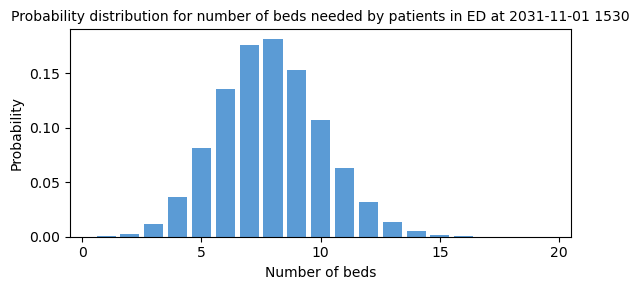

In [26]:
from viz.prob_dist_plot import prob_dist_plot

title_ = f'Probability distribution for number of beds needed by patients in ED at {first_record_key} {MODEL__ED_ADMISSIONS__NAME[-4:]}'
prob_dist_plot(prob_dist_data=prob_dist[first_record_key]['agg_predicted'], 
    title=title_,  
    include_titles=True)

## Generate aggregate predictions for each prediction time

The following cell does the same as above for all five prediction times. 

In [28]:
from prepare import prepare_for_inference, prepare_snapshots_dict
from load import get_model_name
from aggregate import get_prob_dist

prob_dist_dict_all = {}
# Process each time of day
for _prediction_time in prediction_times:

    print("\nProcessing :" + str(_prediction_time))
    
    MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', _prediction_time)

    # prepare data 
    X_test, y_test, model = prepare_for_inference(model_file_path, 
        'ed_admission', 
        prediction_time = _prediction_time, 
        data_path = Path(data_file_path, visits_csv_path), 
        single_snapshot_per_visit = False)


    # select the snapshots to include in the probability distribution, 
    snapshots_dict = prepare_snapshots_dict(
        visits[(visits.training_validation_test == 'test') &
         (visits.prediction_time == _prediction_time)]
        )
    
    # get probability distribution for this time of day
    prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME] = get_prob_dist(
            snapshots_dict, X_test, y_test, model
        )
    


Processing :(6, 0)
Calculating probability distributions for 182 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 100 snapshot dates
Processed 110 snapshot dates
Processed 120 snapshot dates
Processed 130 snapshot dates
Processed 140 snapshot dates
Processed 150 snapshot dates
Processed 160 snapshot dates
Processed 170 snapshot dates
Processed 180 snapshot dates
Processed 182 snapshot dates

Processing :(9, 30)
Calculating probability distributions for 182 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed

## Plot qq plot for each time of day

A  qq plot compares a predicted distribution to an observed distribution. In this case, the predicted distribution is the combined set of probability distributions (one for each snapshot date in the test set) at the given prediction time. The observed distribution is derived from the actual number of patients who were later admitted in each of those snapshot dates. 

If the predicted and observed distributions are similar, the qq plot should adhere closely to the y = x line in the plot. 


Processing :(6, 0)
ed_admission_0600

Processing :(9, 30)
ed_admission_0930

Processing :(12, 0)
ed_admission_1200

Processing :(15, 30)
ed_admission_1530

Processing :(22, 0)
ed_admission_2200


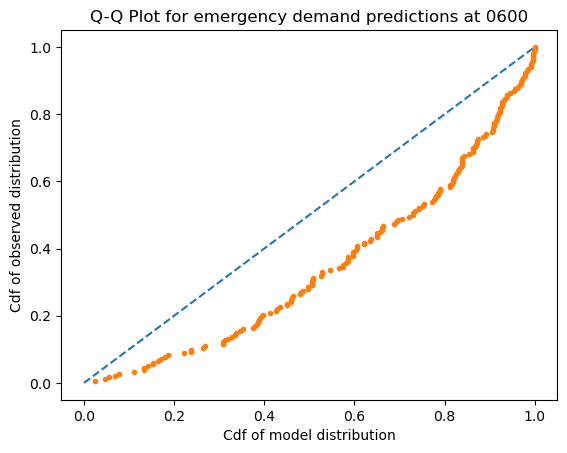

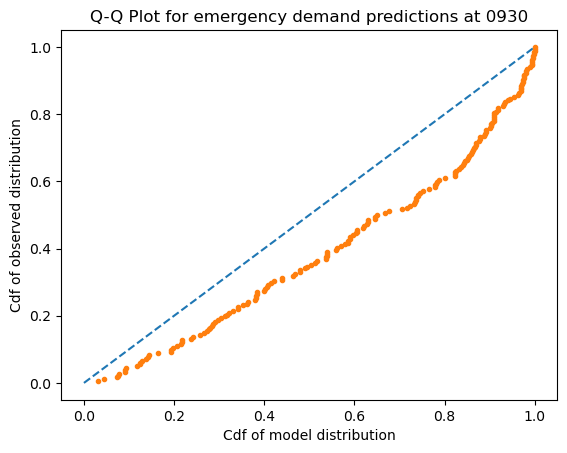

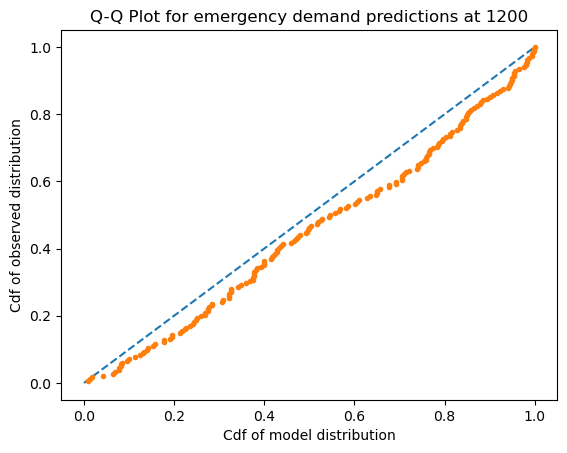

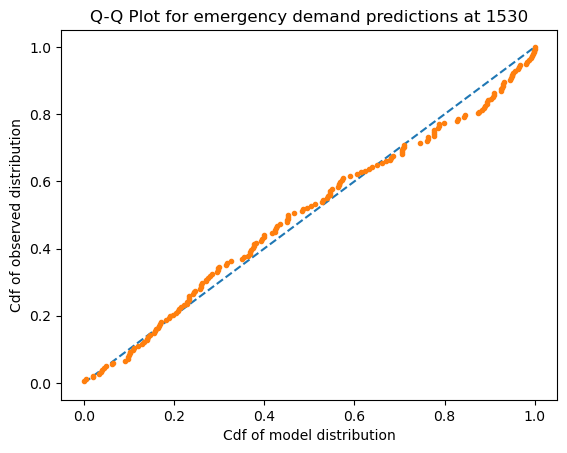

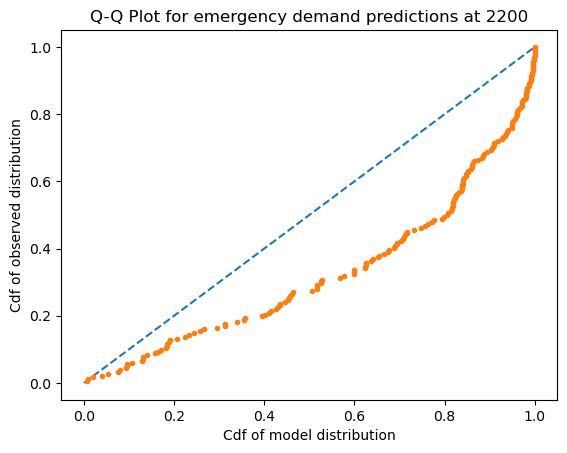

In [29]:
from viz.qq_plot import qq_plot

for _prediction_time in prediction_times:

    print("\nProcessing :" + str(_prediction_time))
    
    # retrieve a name for the model based on the time of day it is trained for
    hour_, min_ = _prediction_time
    min_ = f"{min_}0" if min_ % 60 == 0 else str(min_)
    MODEL__ED_ADMISSIONS__NAME = 'ed_admission_' + f"{hour_:02}" + min_
    print(MODEL__ED_ADMISSIONS__NAME)
    
    title_ = 'Q-Q Plot for emergency demand predictions at ' + f"{hour_:02}" + min_

    plt = qq_plot(snapshots_dict.keys(), prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME], title_)
    
    # use model name in the path for saving the plot
    qq_plot_path = media_file_path / MODEL__ED_ADMISSIONS__NAME 
    qq_plot_path = qq_plot_path.with_suffix('.png')
    
    plt.savefig(qq_plot_path)
        


From the plots above, the 1200 and 1530 predictions perform very well, while the other models tend to underestimate the probability of admission. At 1200 and 1530, there are more patients in the ED/SDEC and most likely a greater diversity of patients, since more people with minor injuries or issues present during the day. It may be easier for models to differentiate between patients at these times. 